# Compare graph-tool to networkx

In [1]:
import qtensor as qtn
import networkx as nx
import graph_tool as gt
from functools import partial
import matplotlib.pyplot as plt

2020-11-29 10:34:01,647- WARNING•	QuickBB solver is unavailable
2020-11-29 10:34:01,649- WARNING•	Tamaki solver is unavailable: No path /usr/lib/python3.8/site-packages/thirdparty/tamaki_treewidth


## Generate problem

In [1119]:
p = 6

In [1120]:
G = qtn.toolbox.bethe_graph(p=p, degree=3)

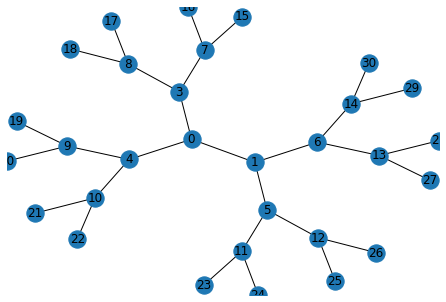

In [1102]:
nx.draw_kamada_kawai(G, with_labels=True)

In [1121]:
def bethe_linegraph(p):
    composer = qtn.DefaultQAOAComposer(G, gamma=[.1]*p, beta=[.3]*p)
    composer.energy_expectation_lightcone((0, 1))

    tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(composer.circuit)
    LG = tn.get_line_graph()
    return LG
LG = bethe_linegraph(p)

Text(0.5, 1.0, 'Line graph of circuit')

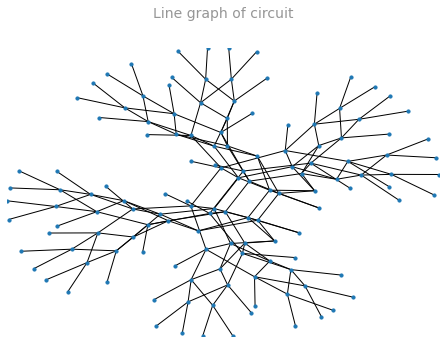

In [1104]:
nx.draw_kamada_kawai(LG, node_size=10)
plt.title('Line graph of circuit')

## Networkx timing

In [556]:
%%timeit
qtn.utils.get_neighbours_peo(LG)

216 ms ± 9.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Max nghs: 22
Path len 1242


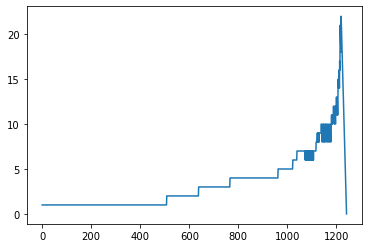

In [931]:
peo, path = qtn.utils.get_neighbours_peo(LG)
plt.plot(path)
print('Max nghs:', max(path))
print('Path len', len(path))

## Graph-tool

In [38]:
import graph_tool.draw, graph_tool.centrality
gt_draw = partial(gt.draw.graph_draw, output_size=(200, 200))

[0, 1, 2, 3, 4, 5, 6] [<Vertex object with index '0' at 0x7f22a576b8d0>, <Vertex object with index '1' at 0x7f22a576ba50>, <Vertex object with index '2' at 0x7f22a576b9f0>, <Vertex object with index '3' at 0x7f22a576b510>, <Vertex object with index '4' at 0x7f22a576b570>, <Vertex object with index '5' at 0x7f22a576bc90>, <Vertex object with index '6' at 0x7f22a576b2d0>]


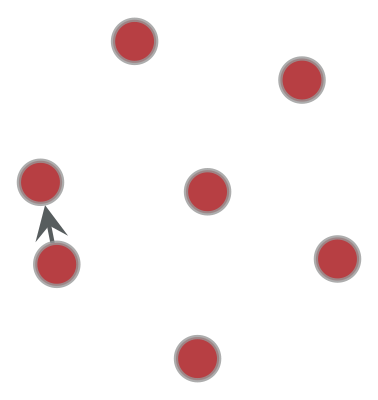

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f22a5824610, at 0x7f22a5822820>

In [375]:
g = gt.Graph()
g.add_edge(5, 6)
print(list(g.vertex_index), list(g.vertices()))
gt_draw(g)

In [376]:
g.remove_vertex(3)
print(list(g.vertex_index), list(g.vertices()))

[0, 1, 2, 3, 4, 5] [<Vertex object with index '0' at 0x7f22a576b2d0>, <Vertex object with index '1' at 0x7f22a576b150>, <Vertex object with index '2' at 0x7f22a576b030>, <Vertex object with index '3' at 0x7f22a576b930>, <Vertex object with index '4' at 0x7f22a576bd50>, <Vertex object with index '5' at 0x7f22a576b570>]


### Convert nx to graph-tool format

In [713]:
def nx_to_gt(G):
    G = nx.convert_node_labels_to_integers(G)
    edges = G.edges()
    g = gt.Graph()
    g.add_edge_list(edges)
    return g

In [714]:
G_gt = nx_to_gt(G)
LG_gt = nx_to_gt(LG)


### Basic drawing

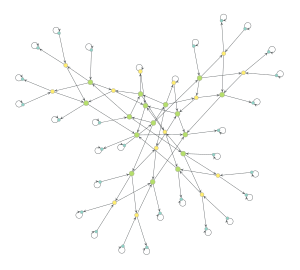

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f229f2c54c0, at 0x7f22a556b610>

In [715]:
deg = LG_gt.degree_property_map("total")
gt_draw(LG_gt, vertex_size=deg, vertex_fill_color=deg, fmt='svg', output_size=(300,300))

### Draw with graphviz

In [11]:
%%disable
! yes | pacman -S graphviz
! pip install graphviz

UsageError: Cell magic `%%disable` not found.


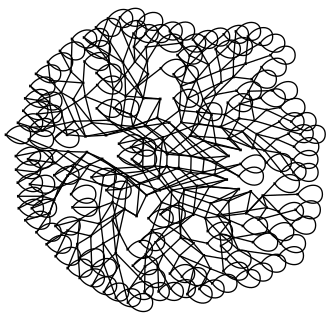

In [12]:
from IPython.display import Image
pos = gt.draw.graphviz_draw(LG_gt, output='/tmp/bethe_tmp.png')
Image(filename='/tmp/bethe_tmp.png') 

In [186]:
%load_ext line_profiler
%load_ext heat

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1164]:
import numpy as np
from itertools import combinations

def simplify_graph(g):
    gt.stats.remove_self_loops(g)
    gt.stats.remove_parallel_edges(g)
    return g

def greedy_peo_graphtool_global(g, stop=np.inf):
    g = g.copy()
    g = simplify_graph(g)
    #g.set_fast_edge_removal(fast=False)
    path = []
    n = 0
    while g.num_vertices():
        deg = g.degree_property_map("total").get_array()
        # deg = np.sum(gt.spectral.adjacency(g), axis=0)
        # deg = np.array(deg).flatten()
        #deg = g.get_total_degrees(list(g.vertices()))
        best = np.argmin(deg)
        best_deg = deg[best]
        path.append(best_deg)
        ngs = g.get_all_neighbours(best)
        #print('Best',  best, 'deg', best_deg)
        new_edges = list(combinations(ngs, 2))
        #print('new', ngs,  new_edges)
        if len(new_edges)>0:
            exist_edges = []
            for u in ngs:
                exist_edges += [(u, v) for v in g.get_all_neighbours(u)]
            #print(exist_edges)
            new_edges = set(new_edges)-set(exist_edges)
            #print(new_edges)
            if len(new_edges)>0:
                g.add_edge_list(new_edges)
                
        g.remove_vertex(best, fast=True)
        n+=1
        if n>stop:
            return path
        if best_deg>100:
            raise Exception("wtf")
    return path

### Graph-tool orerer

In [1165]:
    
def greedy_peo_graphtool(g, stop=np.inf):
    g = g.copy()
    g = simplify_graph(g)
    #g.set_fast_edge_removal(fast=False)
    path = []
    n = 0
    ngs = np.arange(g.num_vertices())
    deg = list(g.degree_property_map("total").get_array())
    while g.num_vertices():
        # deg = g.degree_property_map("total").get_array()
        # deg = np.sum(gt.spectral.adjacency(g), axis=0)
        # deg = np.array(deg).flatten()
        
        deg_local = g.get_total_degrees(ngs)
        #print(f'{n}: Degrees of {ngs} are', deg_local)
        for x, y in zip(ngs, deg_local):
            deg[x] = y
        
        #print('deg', deg)
        best = deg.index(min(deg))
        best_deg = deg.pop(best)
        #print(f'Best degree is at {best} equal', best_deg)
        path.append(best_deg)
        
        ngs = g.get_all_neighbours(best)
        #print(f'Neighbours of best {best}: {ngs}')
        new_edges = list(combinations(ngs, 2))
        #print('new', ngs,  new_edges)
        if len(new_edges)>0:
            exist_edges = []
            for u in ngs:
                exist_edges += [(u, v) for v in g.get_all_neighbours(u)]
            #print(exist_edges)
            new_edges = set(new_edges)-set(exist_edges)
            #print(new_edges)
            if len(new_edges)>0:
                g.add_edge_list(new_edges)
            #gt.stats.remove_parallel_edges(g)
            #print(f'Added {len(new_edges)} edges')
        g.remove_vertex(best)
        ngs[ngs>best]-=1
        #print(f'{n}: Removed vertex {best} left: {g.num_vertices()}')
        n+=1
        if n>stop:
            return path
        if best_deg>100:
            raise Exception("wtf")
    return path

    

In [1081]:
LG_gt = nx_to_gt(LG)
LG_gt.set_directed(False)

In [1166]:
%lprun -f greedy_peo_graphtool_global greedy_peo_graphtool_global(LG_gt.copy())

In [1167]:
%lprun -f greedy_peo_graphtool greedy_peo_graphtool(LG_gt.copy())

In [1082]:
%%timeit
path_gt = greedy_peo_graphtool(LG_gt)

164 ms ± 59.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1149]:
%%timeit
path_gt = greedy_peo_graphtool_global(LG_gt)

7.52 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1155]:
path_gt = greedy_peo_graphtool_global(LG_gt)

In [1153]:
path_gt = greedy_peo_graphtool(LG_gt)

Path len 1242
Max ngs 18


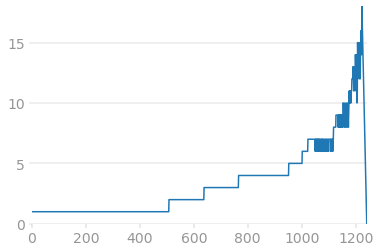

In [1156]:
plt.plot(path_gt)

print("Path len", len(path_gt))
print("Max ngs", max(path_gt))

In [626]:
import operator

## Networkx orderer

In [1053]:
def get_neighbours_peo(old_graph, max_width=np.inf, max_steps=np.inf):
    graph = old_graph.copy()
    graph.remove_edges_from(nx.selfloop_edges(old_graph))
    peo = []
    nghs = []

    while graph.number_of_nodes():
        ###start = time.time()
        adj = graph.adjacency()
        costs = list( map(len, map(operator.itemgetter(1), adj)))
        #costs = list(graph.degree) ###costtime = time.time() - start
        if len(peo)>max_steps:
            return peo, nghs

        ###start = time.time()
        best_idx = costs.index(min(costs))
        #print('bestix',best_idx)
        best_degree = costs[best_idx]
        if best_degree>max_width:
            return peo, nghs
        best_node = list(graph.nodes())[best_idx]
        peo.append(int(best_node))
        #print('bestnode', best_node, 'deg', best_degree, 'costs', costs)
        nghs.append(int(best_degree))
        #nodeiter_time = time.time() - start


        #start = time.time()
        #qtree.graph_model.eliminate_node(graph, best_node)
        neighbors_wo_node = set(graph[best_node])
        while best_node in neighbors_wo_node:
            neighbors_wo_node.remove(best_node)

        #print('ngs', neighbors_wo_node)
        graph.remove_node(best_node)

        # prepare new tensor
        if len(neighbors_wo_node) > 1:
            graph.add_edges_from(combinations(neighbors_wo_node, 2))
            #eltime = time.time() - start
        #pbar.set_postfix(costiter=1/costtime, nodeiter=1/nodeiter_time, eliter=1/eltime ,costtime=costtime, nodeiter_time=nodeiter_time, eltime=eltime)
    return peo, nghs


In [1055]:
%lprun -f get_neighbours_peo get_neighbours_peo(LG)

In [1076]:
%%timeit
get_neighbours_peo(LG)

185 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Optimized for locality

This variant scales differently: there are no loops on nodes within main loop.

Scaling: $$O(w^2N)$$ where $w$ is contraction width 

In [1214]:
def get_neighbours_peo_opt(old_graph, max_width=np.inf, max_steps=np.inf):
    graph = old_graph.copy()
    #graph = nx.convert_node_labels_to_integers(graph)
    graph.remove_edges_from(nx.selfloop_edges(old_graph))
    peo = []
    degree_path = []
    adj = graph.adjacency()
    degs = np.array(list( map(len, map(operator.itemgetter(1), adj))))
    nodes = np.array(list(graph.nodes()))
    nghs = nodes

    while graph.number_of_nodes():
        ###start = time.time()
        #costs = list(graph.degree) ###costtime = time.time() - start
        
        local_deg = list(map(operator.itemgetter(1), graph.degree(nghs)))
        degs[list(nghs)] = local_deg
        best_ix = degs.argmin()
        best = degs[best_ix]
        best_node = best_ix
        peo.append(best_node)
        degree_path.append(best)
        degs[best_ix] = 1000_000
        if best>100:
            print('best', best, 'local deg', local_deg)
        
        #start = time.time()
        #qtree.graph_model.eliminate_node(graph, best_node)
        nghs = set(graph[best_node])
        while best_node in nghs:
            nghs.remove(best_node)

        #print('ngs', neighbors_wo_node)
        graph.remove_node(best_node)

        # prepare new tensor
        if len(nghs) > 1:
            new_edges = combinations(nghs, 2)
            existing = []
            for u in nghs:
                existing += [(u, v) for v in graph[u]]
            
            new_edges = set(new_edges) - set(existing)#[e for e in new_edges if e not in existing]
            if len(new_edges)>0:
                graph.add_edges_from(new_edges)
            #eltime = time.time() - start
        #pbar.set_postfix(costiter=1/costtime, nodeiter=1/nodeiter_time, eliter=1/eltime ,costtime=costtime, nodeiter_time=nodeiter_time, eltime=eltime)
    return peo, degree_path


In [1216]:
LG = nx.convert_node_labels_to_integers(LG)

In [1217]:
%lprun -f get_neighbours_peo_opt [get_neighbours_peo_opt(LG) for _ in range(10)]

In [1218]:
%%timeit
get_neighbours_peo_opt(LG)

95.8 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1219]:
%%timeit
get_neighbours_peo(LG)

255 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


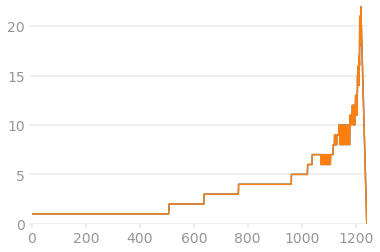

In [1220]:
_, path_opt =  get_neighbours_peo_opt(LG) 
plt.plot(path_opt)
plt.plot(path)
assert np.allclose(path_opt, path)

## Networkit

In [1079]:
import networkit as nk

In [851]:
g = nk.Graph()
g.addNodes(5)
g.addEdge(3,4)
g.addEdge(3,4)
g.removeNode(2)
list(g.iterNodes()), list(g.iterEdges())


([0, 1, 3, 4], [(3, 4), (3, 4)])

In [1122]:
LG_nk = nk.nxadapter.nx2nk(LG)

### Networkit orderer

In [1123]:
def greedy_peo_networkit(G, max_width=np.inf, max_steps=np.inf):
    G = nk.Graph(G)
    G.removeSelfLoops()
    path = []
    while G.numberOfNodes():
        nodes = list(G.iterNodes())
        nodes = list(nodes)
        costs = list(map(G.degree, nodes))
        
        best = min(costs)
        if best>max_width or len(path)>max_steps:
            return path
        path.append(best)
        
        best_ix = costs.index(best)
        best_node = nodes[best_ix]
        ngs = list(G.iterNeighbors(best_node))
        #print('best', best_node, 'bestix', best_ix ,'lenngs', len(ngs), ngs)
        new_edges = list(combinations(ngs, 2))
        #print('lennedges', len(new_edges))
        if len(new_edges)>0:
            existing = []
            for u in ngs:
                existing += [(u, v) for v in G.iterNeighbors(u)]
            
            new_edges = set(new_edges) - set(existing)#[e for e in new_edges if e not in existing]
            if len(new_edges)>0:
                [G.addEdge(*e) for e in new_edges]
            #print(f'added {len(new_edges)} edges')
        G.removeNode(best_node)
        if best>100:
            raise Exception('wtf')
    return path

In [1128]:
%lprun -f greedy_peo_networkit [greedy_peo_networkit(LG_nk) for _ in range(10)]

In [1129]:
%%timeit
greedy_peo_networkit(LG_nk)

145 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Optimized orderer

In [1182]:
def greedy_peo_networkit_opt(G, max_width=np.inf, max_steps=np.inf):
    G = nk.Graph(G)
    G.removeSelfLoops()
    path = []
    nodes = np.array(list(G.iterNodes()))
    degs = np.array(list(map(G.degree, nodes)))
    nghs = nodes
                     
    while G.numberOfNodes():
        loc_deg = list(map(G.degree, nghs))
        degs[nghs] = loc_deg
        best_ix = degs.argmin()
        best = degs[best_ix]
        best_node = nodes[best_ix]
        path.append(best)
     #  if best>max_width:
     #      return path 
     #  if len(path)>max_steps:
     #      return path
        
        nghs = list(G.iterNeighbors(best_node))
        #print('best', best_node, 'bestix', best_ix ,'lenngs', len(ngs), ngs)
        G.removeNode(best_node)
        degs[best_ix] = 1000_000
        #print('lennedges', len(new_edges))
        #print('lennedges', len(new_edges))
        if len(nghs)>1:
            new_edges = list(combinations(nghs, 2))
            existing = []
            for u in nghs:
                existing += [(u, v) for v in G.iterNeighbors(u)]
            
            new_edges = set(new_edges) - set(existing)#[e for e in new_edges if e not in existing]
            if len(new_edges)>0:
                [G.addEdge(*e) for e in new_edges]
            #print(f'added {len(new_edges)} edges')
            
      # for u in nghs:
      #     existing = list(G.iterNeighbors(u))
      #     for v in nghs:
      #         if v not in existing:
      #             if u!=v:
      #                 G.addEdge(u, v)
      #     #print(f'added {len(new_edges)} edges')
        if best>100:
            raise Exception('wtf')
    return path

In [1131]:
%lprun -f greedy_peo_networkit_opt [greedy_peo_networkit_opt(LG_nk) for x in range(10)]

In [1132]:
%%timeit
greedy_peo_networkit_opt(LG_nk)

36.7 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1183]:
path_nk = greedy_peo_networkit(LG_nk)
path_nk = greedy_peo_networkit_opt(LG_nk)

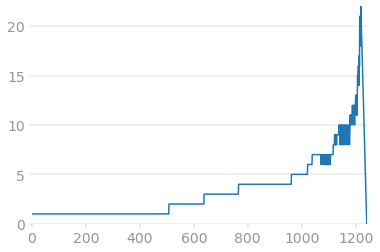

In [1134]:
assert all(x==y for x, y in zip(path_nk, path))
plt.plot(path_nk)

## Perfplot

In [1135]:
import perfplot

In [1136]:
%timeit nx_to_gt(LG)

23 ms ± 814 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1137]:
%timeit nk.nxadapter.nx2nk(LG)

7.44 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Bethe lattice QAOA

Output()

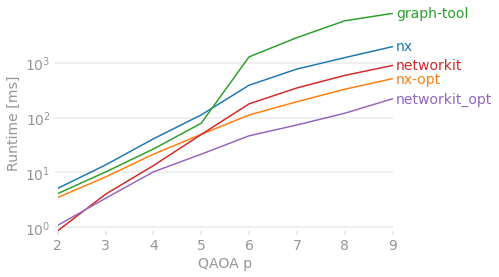

In [1224]:
perfplot.show(
    setup=lambda n: nx.convert_node_labels_to_integers(bethe_linegraph(n))
    ,kernels=[
        lambda g: qtn.utils.get_neighbours_peo(g)[1]
        ,lambda g: get_neighbours_peo_opt(g)
        ,lambda g: greedy_peo_graphtool(nx_to_gt(g))
        ,lambda g: greedy_peo_networkit(nk.nxadapter.nx2nk(g))
        ,lambda g: greedy_peo_networkit_opt(nk.nxadapter.nx2nk(g))
    ]
    ,labels=["nx", "nx-opt", "graph-tool", "networkit", "networkit_opt"]
    ,n_range=[p for p in range(2, 10)]
    ,xlabel="QAOA p"
    ,time_unit='ms'
    ,logy=True
    ,equality_check=None
)

### Random regular graphs

Output()

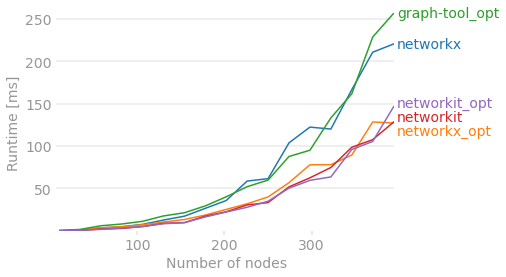

In [1221]:
perfplot.show(
    setup=lambda n: nx.random_regular_graph(3, n)
    ,kernels=[
        lambda g: qtn.utils.get_neighbours_peo(g)[1]
        #,lambda g: greedy_peo_graphtool_global(nx_to_gt(g))
        ,lambda g: get_neighbours_peo_opt(g)
        ,lambda g: greedy_peo_graphtool(nx_to_gt(g))
        ,lambda g: greedy_peo_networkit(nk.nxadapter.nx2nk(g))
        ,lambda g: greedy_peo_networkit_opt(nk.nxadapter.nx2nk(g))
    ]
    ,labels=["networkx", "networkx_opt", "graph-tool_opt", "networkit", "networkit_opt"]
    ,n_range=[k for k in range(10, 400, 24)]
    ,xlabel="Number of nodes"
    ,time_unit='ms'
    ,equality_check=None
)

Output()

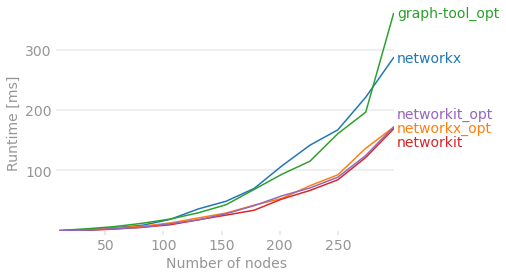

In [1227]:
perfplot.show(
    setup=lambda n: nx.random_regular_graph(4, n)
    ,kernels=[
        lambda g: qtn.utils.get_neighbours_peo(g)[1]
        #,lambda g: greedy_peo_graphtool_global(nx_to_gt(g))
        ,lambda g: get_neighbours_peo_opt(g)
        ,lambda g: greedy_peo_graphtool(nx_to_gt(g))
        ,lambda g: greedy_peo_networkit(nk.nxadapter.nx2nk(g))
        ,lambda g: greedy_peo_networkit_opt(nk.nxadapter.nx2nk(g))
    ]
    ,labels=["networkx", "networkx_opt", "graph-tool_opt", "networkit", "networkit_opt"]
    ,n_range=[k for k in range(10, 300, 24)]
    ,xlabel="Number of nodes"
    ,time_unit='ms'
    ,equality_check=None
)

### Cycle graphs

Output()

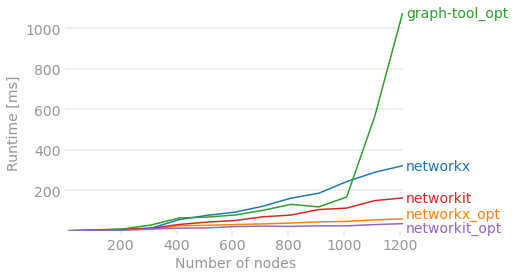

In [1230]:
perfplot.show(
    setup=lambda n: nx.cycle_graph(n)
    ,kernels=[
        lambda g: qtn.utils.get_neighbours_peo(g)[1]
        #,lambda g: greedy_peo_graphtool_global(nx_to_gt(g))
        ,lambda g: get_neighbours_peo_opt(g)
        ,lambda g: greedy_peo_graphtool(nx_to_gt(g))
        ,lambda g: greedy_peo_networkit(nk.nxadapter.nx2nk(g))
        ,lambda g: greedy_peo_networkit_opt(nk.nxadapter.nx2nk(g))
    ]
    ,labels=["networkx", "networkx_opt", "graph-tool_opt", "networkit", "networkit_opt"]
    ,n_range=[k for k in range(10, 1300, 100)]
    ,xlabel="Number of nodes"
    ,time_unit='ms'
    ,equality_check=None
)

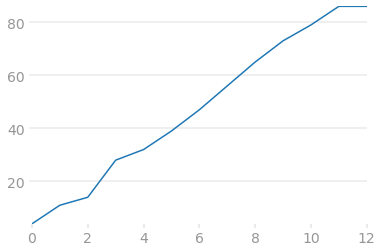

In [1172]:
plt.plot([max(
    greedy_peo_networkit_opt(
        nk.nxadapter.nx2nk(
            nx.random_regular_graph(3, x)
        )
    )) for x in range(20,480,36) ])

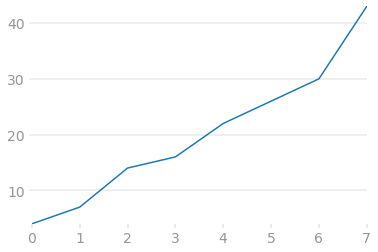

In [1174]:
plt.plot([max(
    greedy_peo_networkit_opt(
        nk.nxadapter.nx2nk(
            bethe_linegraph(p)
        )
    )) for p in range(2,10) ])

In [1175]:
%lprun -f greedy_peo_graphtool_global greedy_peo_graphtool_global(nx_to_gt(nx.random_regular_graph(3, 400)))

In [1176]:
%lprun -f greedy_peo_graphtool greedy_peo_graphtool(nx_to_gt(nx.random_regular_graph(3, 400)))

In [1169]:
%lprun -f greedy_peo_networkit_opt greedy_peo_networkit_opt(nk.nxadapter.nx2nk(nx.random_regular_graph(3, 200)))